# Prepare data and libraries
Based on the ISIC Challenge 2020 train and test (both "corrected") dataset.

* https://www.isic-archive.com/
* https://challenge.isic-archive.com/data/#2020
* https://www.dicomstandard.org/ai

* curl -o ISIC_2020_Train_DICOM_corrected.zip https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Train_DICOM_corrected.zip
* curl -o ISIC_2020_Test_DICOM_corrected.zip https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Test_DICOM_corrected.zip
* curl -o ISIC_2020_Training_GroundTruth.csv https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_GroundTruth.csv

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
# The following does not seem to work :(
#!cd /opt/dlami/nvme/
#!pwd
import os
os.chdir('/mnt/efs/fs1/')
!pwd

/mnt/efs/fs1


In [3]:
## To load local modules, not sure if this works
#import os
#import sys
#module_path = os.path.abspath(os.path.join('..'))
#if module_path not in sys.path:
#    sys.path.append(module_path)

In [4]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

(Optional) Define the default font sizes to make the figures prettier:

In [6]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [7]:
# If you have google colab gpu
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Not connected to a GPU


In [8]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('Not using a high-RAM runtime')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 4.1 gigabytes of available RAM

Not using a high-RAM runtime


# ISIS/DICOM Testing

In [9]:
#!pip install pydicom

In [10]:
import pydicom
from pydicom.data import get_testdata_file

In [11]:
#dcm_filename = "./isic/test/ISIC_7977981.dcm"  
dcm_filename = "./isic/train/ISIC_9999806.dcm"
dcm_path = os.path.join(".",dcm_filename)
dcm_img = pydicom.dcmread( dcm_path, force = True )
print(dcm_img)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 218
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: VL Photographic Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.5962.99.1.1145.9492.1620348114777.1.1.1.1.1
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.5962.99.2
(0002, 0013) Implementation Version Name         SH: 'PIXELMEDJAVA001'
(0002, 0016) Source Application Entity Title     AE: 'OURAETITLE'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0014) Instance Creator UID                UI: 1.3.6.1.4.1.5962.99.3
(0008, 0016) SOP Class UID                       UI: VL Photographic Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.

(256, 256, 3)


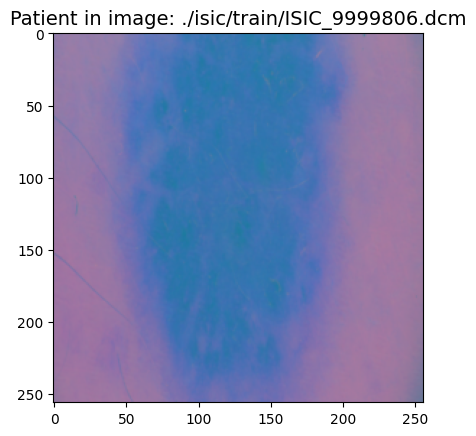

In [12]:
import skimage

img_array = dcm_img.pixel_array
#print(img_array.shape)
# img_array seems to be regular array (or perhaps numpy), compatible with tensorflow resize

#img_array_resized = tf.image.resize(img_array, [img_height, img_width])
img_array_resized = skimage.transform.resize(img_array, (256, 256))

# img_array_resized is now a tensor and can be converted into numpy to display
print(img_array_resized.shape)

#plt.imshow(img_array.numpy().astype("uint8"))
plt.imshow(img_array_resized)

#if label == 0:
#    category = "doesn't have cancer"
#elif label == 1:
#    category = "has cancer"

plt.title(f'Patient in image: {dcm_filename}');

In [13]:
import pandas as pd
isic_metadata_df=pd.read_csv('./isic/ISIC_2020_Training_GroundTruth.csv')
isic_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [14]:
isic_metadata_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [29]:
def lookup_dcm_path( isic_metadata_df, file_path ):
    # NB: file_path should be str object with path to the dcm file
    #file_path = f.numpy().decode("utf-8")
    #file_path = str(f)
    imgid = file_path.split("/")[-1]
    # Get rid of extension so can exactly match the dataframe image_id
    img_name = imgid.replace(".dcm", "")
    row = isic_metadata_df.loc[ isic_metadata_df["image_name"] == img_name ]
    # Should be only one row, i.e. img_name exists and is unique in the dataframe
    #print( f"FOUND {row.shape}" )
    #print( img_name )
    #print( row )
    #num_rows = row.shape[0]
    #if( num_rows > 0 ):
    # lesion_id      image_id  dx    dx_type   age   sex     localization
    # the row lookup returns a dataframe or series, but just one value, use iat
    patient_id = row["patient_id"].iat[0]
    diagnosis  = row["diagnosis"].iat[0]
    benign  = row["benign_malignant"].iat[0]
    age     = row["age_approx"].iat[0]
    sex     = row["sex"].iat[0]
    localization = row["anatom_site_general_challenge"].iat[0]
    return [patient_id, img_name, diagnosis, benign, age, sex, localization]
      

In [30]:
example_metadata = lookup_dcm_path( isic_metadata_df, "./ISIS/train/ISIC_9999806.dcm" )
print(example_metadata)

['IP_0046310', 'ISIC_9999806', 'nevus', 'benign', 45.0, 'male', 'torso']


## 1. Custom Dataset
Based on https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

Based on https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [31]:
import pathlib
import numpy as np

In [34]:
csv_file_name='./isic/ISIC_2020_Training_GroundTruth.csv'
root_dir_name="./isic/train"

data_dir = pathlib.Path(root_dir_name) # NB: changing type froom str to Path
file_paths = list(data_dir.glob('*.dcm'))
image_count = len(file_paths)
print(image_count)
for i in range(image_count):
    file_path = file_paths[i]
    print(f"file_path={file_path}")
    if( i > 10 ):
        break

33126
file_path=isic/train/ISIC_0183290.dcm
file_path=isic/train/ISIC_8066487.dcm
file_path=isic/train/ISIC_5568834.dcm
file_path=isic/train/ISIC_4755369.dcm
file_path=isic/train/ISIC_0623444.dcm
file_path=isic/train/ISIC_5775708.dcm
file_path=isic/train/ISIC_3255602.dcm
file_path=isic/train/ISIC_6153134.dcm
file_path=isic/train/ISIC_3805025.dcm
file_path=isic/train/ISIC_2616987.dcm
file_path=isic/train/ISIC_7582818.dcm
file_path=isic/train/ISIC_9488163.dcm


In [59]:
import pathlib
from torch.utils.data import Dataset
#from torchvision.io import read_image

# Three ways of reading images (two in the tutorials)
# Transforms are designed for Scikit-image, however, decided to use Torchvision
# Torchvision returns tensor (can be converted to PIL for displaying)
# Scikit-image returns numpy skimage.io.imread(os.path.join('data/faces/', img_name)
# PIL returns pillow object me thinks PIL.Image.open(image_path)
# https://stackoverflow.com/questions/68207510/how-to-use-torchvision-io-read-image-with-image-as-variable-not-stored-file
#import skimage

import pandas as pd
import os

class DicomDataset(Dataset):
    """Isic dataset"""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.metadata_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        # We really only need a list of str file paths, no need for root_dir
        # more of a convenience.  Support both root_dir or list of filepaths
        if( type(root_dir) == str ):
            #print("USING ROOT DIR")
            # The dataframe metadata may have  more records than we have
            # files in the directory, so use the files
            #data_path = pathlib.Path(root_dir) # NB: changing type from str to Path
            #self.file_paths = list(data_path.glob('*/*.jpg'))
    
            # Prefer pure Python str to posixpath, causes lots of problems otherwise
            data_path = pathlib.Path(root_dir) # NB: changing type from str to Path
            self.file_paths = list()
            for posixpath in list(data_path.glob('*.dcm')):
                self.file_paths.append( str(posixpath) )
        elif( type(root_dir) == list ):
            #print("USING LIST")
            self.file_paths = root_dir
        else:
            raise ValueError(f"Unsupported type for root_dir {type(root_dir)}")
        
        
        self.image_count = len(self.file_paths)
        #print(image_count)
        #for i in range(image_count):
        #    file_path = file_paths[i]
        # Manually map target to ints   (required for models)
        self.class_names = ['benign', 'malignant']
        
    
    def __len__(self):
        return self.image_count

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        file_path = self.file_paths[idx]
        row = self.lookup_path( file_path )

        #img_name = sample['imgid']
        #image = io.imread(img_name)
        # Frankly not sure why we don't just store as Pytorch tensor
        # example stores as a numpy image and then transforms
        # In any cases, the dimensions are different and so code is not compatible
        # specifically the resize and crop are written for numpy :(
        # Perhaps one day can rewrite for tensors but fine for now
        #image_tensor = torchvision.io.read_image( str(file_path) )
        #sample['image'] = image_tensor
        
        #image_np = skimage.io.imread(file_path) # dtype=uint8
        dcm_img = pydicom.dcmread( file_path, force = True )
        image_np = dcm_img.pixel_array
        
        # [[[209 155 181]
        #  [210 154 183]
        #  [209 154 183]
        #  ...
        # need float32, also imshow, if float, expects  between [0,1]
        # This is also perhaps nice for training as normalised.
        image_np = np.float32(image_np)/255.0
        #print( f"image_np={image_np.dtype}" )
        label = self.class_names.index( row['benign_malignant'] )
        sample = (image_np, label)

        # apply any transforms, e.g. resize, crop
        if self.transform:
            sample = self.transform(sample)

        return sample

    def get_class_names( self ):
        return self.class_names

    def get_class( self, index ):
        return self.class_names[index]

    def get_index( self, file_path ):
        return self.file_paths.index(file_path)

    def get_file_path( self, idx ):
        return self.file_paths[idx]
    
    def lookup_path( self, file_path ):
        """
        file_path (type Path) of the file (e.g. ISIC_0034214)
        returns list [lesion_id, image_id, dx, dx_type, age, sex, localization]
        """
        #   image_name    patient_id  sex    age_approx anatom_site_general_challenge diagnosis benign_malignant target
        # 0 ISIC_2637011  IP_7279968  male   45.0       head/neck                     unknown   benign           0
        # 1 ISIC_0015719  IP_3075186  female 45.0       upper extremity               unknown   benign           0
        imgid = file_path.split("/")[-1]
        # Get rid of extension so can exactly match the dataframe image_id
        img_name = imgid.replace(".dcm", "")
        row = isic_metadata_df.loc[ isic_metadata_df["image_name"] == img_name ]
        # Should be only one row, i.e. img_name exists and is unique in the dataframe
        #print( f"FOUND {row.shape}" )
        #print( img_name )
        #print( row )
        #num_rows = row.shape[0]
        #if( num_rows > 0 ):
        # lesion_id      image_id  dx    dx_type   age   sex     localization
        # the row lookup returns a dataframe or series, but just one value, use iat
        image_name = row["image_name"].iat[0]
        patient_id = row["patient_id"].iat[0]
        diagnosis  = row["diagnosis"].iat[0]
        benign   = row["benign_malignant"].iat[0]
        age      = row["age_approx"].iat[0]
        sex      = row["sex"].iat[0]
        location = row["anatom_site_general_challenge"].iat[0]
        sample = {'file_path': file_path, 'image_name': image_name, 'patient_id': patient_id,
                  'diagnosis': diagnosis, 'benign_malignant': benign, 'age': age, 'sex': sex, 'location': location}
        return sample

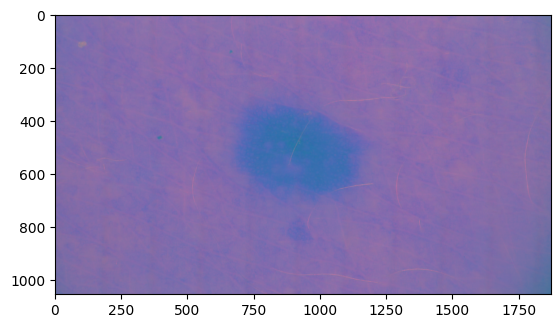

float32


In [60]:
import torchvision.transforms.functional as transform
#from skimage import io
import skimage
def show_skin_image(image_np):
    """Show image"""
    plt.imshow(image_np)
    
    #new_PIL_image = transform.to_pil_image(image_tensor) 
    #plt.imshow(new_PIL_image)
    
    #plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
dcm_img = pydicom.dcmread( 'isic/train/ISIC_0183290.dcm', force = True )
image_np = dcm_img.pixel_array
image_np = np.float32(image_np)/255.0
#image_tensor = torchvision.io.read_image( 'ham/health_tiny/bcc/ISIC_0031284.jpg' )
show_skin_image(image_np)
plt.show()
print(image_np.dtype)

0 (1053, 1872, 3) 0


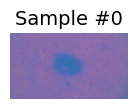

1 (4000, 6000, 3) 0


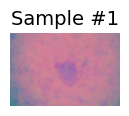

2 (480, 640, 3) 0


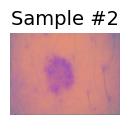

3 (4000, 6000, 3) 0


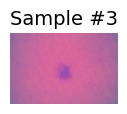

In [61]:
isic_dataset = DicomDataset(csv_file=csv_file_name, root_dir=root_dir_name)

fig = plt.figure()

images_to_show = 4
for i, sample in enumerate(isic_dataset):
    image_tensor, label = sample
    print(i, image_tensor.shape, label)
    
    ax = plt.subplot(1, images_to_show, i + 1)
    plt.tight_layout()
    ax.set_title(f'Sample #{i}')
    ax.axis('off')
    show_skin_image( image_tensor )
    
    if i == images_to_show -  1:
        plt.show()
        break

In [62]:
import numpy as np
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = skimage.transform.resize(image, (new_h, new_w))

        return (img, label)


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]

        return (image, label)


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        #print(image_np.dtype) = uint8
        # default numpy type is float64, causes issues as models expect float32 :(
        return (torch.from_numpy(image), label)

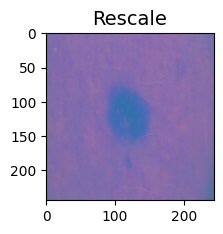

In [64]:
#from torchvision.transforms import v2

#scale = Rescale(256)
scale = Rescale( (244,244) )
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = isic_dataset[0]
#for i, tsfrm in enumerate([scale, crop, composed]):
for i, tsfrm in enumerate([scale]):
    image, label = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_skin_image(image)

plt.show()

Iterating through the dataset
Let’s put this all together to create a dataset with composed transforms. To summarize, every time this dataset is sampled:

An image is read from the file on the fly

Transforms are applied on the read image

Since one of the transforms is random, data is augmented on sampling

We can iterate over the created dataset with a for i in range loop as before.

In [65]:
transformed_dataset = DicomDataset(  csv_file=csv_file_name,
                                   root_dir=root_dir_name,
                                   transform=transforms.Compose([
                                       Rescale( (224,224) ),
                                       #RandomCrop(224),
                                       ToTensor()
                                    ]))

for i, sample in enumerate(transformed_dataset):
    image, label = sample
    print(i, image.size())

    if i == 3:
        break

0 torch.Size([3, 224, 224])
1 torch.Size([3, 224, 224])
2 torch.Size([3, 224, 224])
3 torch.Size([3, 224, 224])


However, we are losing a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:

Batching the data

Shuffling the data

Load the data in parallel using multiprocessing workers.

torch.utils.data.DataLoader is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is collate_fn. You can specify how exactly the samples need to be batched using collate_fn. However, default collate should work fine for most use cases.

0 2
1 2
2 2
3 2


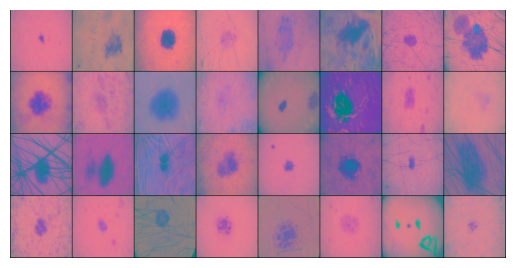

In [69]:
from torch.utils.data import DataLoader
from torchvision import utils

num_threads = 16-2 # assuming 16 CPUs

batch_size = 32
dataloader = DataLoader(transformed_dataset, batch_size=batch_size, shuffle=True, num_workers=num_threads)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, labels_batch = sample_batched
    batch_size = len(images_batch)
    #print(f"batch_size={batch_size}")
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

# if you are using Windows, uncomment the next line and indent the for loop.
# you might need to go back and change ``num_workers`` to 0.

# if __name__ == '__main__':
for i_batch, sample_batched in enumerate(dataloader):
    # NB sample_batched should always be 2, two lists
    #   list of batch_size for images
    #   list of batch_size for labels
    print(i_batch, len(sample_batched) ) 

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [70]:
class_names = transformed_dataset.get_class_names()

total = len(transformed_dataset)
train = int(0.7 * total)
test  = total - train
print(  f"train={train}  test={test}" )
train_set, val_set = torch.utils.data.random_split(transformed_dataset, [train, test])

trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_threads)

train=23188  test=9938


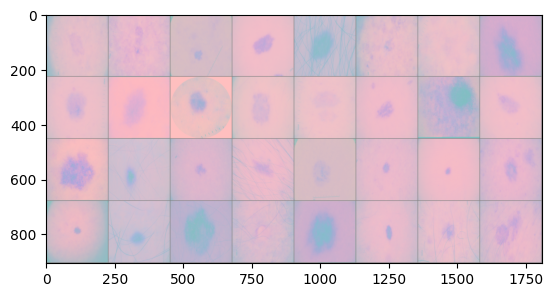

benign benign benign benign benign benign benign benign benign benign benign benign benign benign benign benign benign benign benign benign benign benign benign benign benign benign malignant benign benign benign benign benign


In [71]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{class_names[labels[j]]:5s}' for j in range(batch_size)))

# 2. Define a Convolutional Neural Network

In [73]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Expects images of h=224, w=224
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(7,7), stride=1, padding='same')
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=1, padding='same')
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(64*56*56, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(512, 7)
        #self.softmax = nn.Softmax( dim=0 ) # expect  only one dim

        # Initialise
        self._init_weights(self.conv1)
        self._init_weights(self.conv2)
        self._init_weights(self.fc3)
        self._init_weights(self.fc4)

    def _init_weights(self, module):
        #print(f"Initialising module {module}")
        # https://saturncloud.io/blog/how-to-initialize-weights-in-pytorch-a-guide-for-data-scientists/
        # https://wandb.ai/wandb_fc/tips/reports/How-to-Initialize-Weights-in-PyTorch--VmlldzoxNjcwOTg1
        nn.init.xavier_normal_(module.weight)
        # nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu') # He
        #if isinstance(module, nn.Linear):
        #    module.weight.data.normal_(mean=0.0, std=1.0)
        #    if module.bias is not None:
        #        module.bias.data.zero_()

    
    def forward(self, x):
        verbose = False
        #=========================#
        # input 3x224x224
        x = self.act1(self.conv1(x))
        # output 32x224x224

        # input 32x224x224 
        x = self.pool1(x)
        # output 32x112x112
        if verbose: print(f"output group1 {x.shape}")

        #=========================#
        # input 32x112x112
        x = self.act2(self.conv2(x))
        # input 64x112x112
        
        # input 64x112x112
        x = self.pool2(x)
        # output 64x56x56
        if verbose: print(f"output group2 {x.shape}")

        #=========================#
        # input 64x56x56
        x = self.flat(x)
        # output (64x56x56)
        if verbose: print(f"output flatten {x.shape}")

        #=========================#
        # input (64x56x56)
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # output (512)
        if verbose: print(f"output group3 {x.shape}")

        #=========================#
        # input (512)
        x = self.fc4(x)
        #  output (7)
        if verbose: print(f"output group4 {x.shape}")
        
        # Finally pass through a softmax
        #x = self.softmax(x)
        return x


model = Net()

## 3. Define a Loss function and optimizer
Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [74]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

### Training on GPU?
Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU.

Let’s first define our device as the first visible cuda device if we have CUDA available:

In [75]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [76]:
num_epochs = 5
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 16 == 0:
            print(f'    epoch {epoch+1} batch {i}: loss: {running_loss:.6f}')
        #if i % 100 == 99:    # print every 100 batches
        #    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.6f}')
        #    running_loss = 0.0
    print(f'epoch {epoch + 1}/{num_epochs}: loss: {running_loss:.6f}')

print('Finished Training')

    epoch 1 batch 0: loss: 1.933818
    epoch 1 batch 16: loss: 7.108410
    epoch 1 batch 32: loss: 9.796641


KeyboardInterrupt: 

Let’s quickly save our trained model:

In [ ]:
PATH = './isic_model.pth'
torch.save(model.state_dict(), PATH)

## 5. Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

In [ ]:
testloader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=num_threads)
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{class_names[labels[j]]:5s}' for j in range(batch_size)))

Next, let’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):

In [ ]:
model = Net()
model.load_state_dict(torch.load(PATH))

Okay, now let us see what the neural network thinks these examples above are:

In [ ]:
outputs = model(images)

The outputs are probablities for the 7 classes. The higher the prob for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{class_names[predicted[j]]:5s}'
                              for j in range(batch_size)))

The results seem pretty good. (humm)

Let us look at how the network performs on the whole dataset.

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(val_set)} test images: {100 * correct // total} %')

What are the classes that performed well, and the classes that did not perform well:

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

# Exploratory Data  Analysis

In [ ]:
metadata_df=pd.read_csv(csv_file_name)
metadata_df.info()

In [ ]:
#To analyse basics of Dataset we study first 5 rows of HAAM10000 Dataset
metadata_df.head()

In [ ]:
#Checking for NA
metadata_df.isna().isna().sum()

In [ ]:
metadata_df.describe(include='all')

In [ ]:
import seaborn as sns

In [ ]:
# We need to predict the cancer type, let's check the distribution of the values
g = sns.catplot(x="dx", kind="count", palette='bright', data=metadata_df)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Visualization of Output Classes', fontsize=20)
g.set_xlabels('Classes of Skin Cancer', fontsize=14)
g.set_ylabels('Frequency', fontsize=14)
plt.show()

In [ ]:
#Skin Cancer is confirmed via Hispathology, let's check the breakdown for each type
g = sns.catplot(x="dx", kind="count", hue="dx_type", palette='bright', data=metadata_df)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Skin Cancer by Histopathology', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Histopathology Type')
plt.show()

In [ ]:
# Skin Cancer occurence body localization
g = sns.catplot(x="dx", kind="count", hue="localization", palette='bright', data=metadata_df)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer Localization', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Localization')
plt.show()

In [ ]:
# Skin Cancer occurence by Age
g = sns.catplot(x="dx", kind="count", hue="age", palette='bright', data=metadata_df)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Age', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Age')
plt.show()

In [ ]:
# Skin Cancer occurence by Sex
g = sns.catplot(x="dx", kind="count", hue="sex", palette='bright', data=metadata_df)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Sex', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Sex')
plt.show()

# Fairness Analysis
Create a custom CNN model and train on the data.  Evaluate using the validation set to estimate the model's accuracy.

In [ ]:
# Read in again, makes this section more independent
metadata_df=pd.read_csv(csv_file_name)
metadata_df.head()

In [ ]:
metadata_sample_df = metadata_df.sample(batch_size*2, random_state=123456)
print(class_names)
metadata_sample_df.head()

In [ ]:
# See https://discuss.pytorch.org/t/how-to-retrieve-the-sample-indices-of-a-mini-batch/7948/19
# https://discuss.pytorch.org/t/how-does-one-obtain-indicies-from-a-dataloader/16847/7
def dataset_with_indices(cls):
    """
    Modifies the given Dataset class to return a tuple data, target, index
    instead of just data, target.
    """
    def __getitem__(self, index):
        data, target = cls.__getitem__(self, index)
        return data, target, index
    
    return type(cls.__name__, (cls,), {
        '__getitem__': __getitem__,
    })
DicomDatasetWithIndices = dataset_with_indices(DicomDataset)
#dataset = MNISTWithIndices('~/datasets/mnist')

Create a new dataset with all the images.

In [ ]:
eval_file_paths = list()
for index_df, row in metadata_sample_df.iterrows():
    # health_small/nv/ISIC_0027761.jpg
    dx = row['dx']
    image_id = row['image_id']
    #file_path = f"{root_dir_name}/{dx}/{image_id}.jpg"
    file_path = f"ham/health/{dx}/{image_id}.jpg"
    eval_file_paths.append(file_path)
    #print( f"{index}: dx={dx}  image_id={image_id} file_path={file_path}" )

# This results in data = (img, label, index) instead of just (img,label)
# The index is lookup into the dataset, e.g. eval_dataset[index]
eval_dataset = DicomDatasetWithIndices( csv_file=csv_file_name,
                           root_dir=eval_file_paths,
                           transform=transforms.Compose([
                               Rescale( (224,224) ),
                               #RandomCrop(224),
                               ToTensor()
                            ]))
print(f"Evaluation Dataset contains {len(eval_dataset)} instances")
print(f"Dataframe has {metadata_sample_df.shape}")
print(f"List eval_file_paths has {len(eval_file_paths)}")

In [ ]:
evalloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads)
dataiter = iter(evalloader)
images, labels, indexes = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{class_names[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
y_true = list()
y_pred = list()

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
k = 0
with torch.no_grad():
    for data in evalloader:
        # My hope is that the loader (we can shuffle because index is returned) and dataframe are "aligned"
        # Confirmed that this is indeed the case with the modified datase "with indices"
        images, labels, indexes = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #print(f"=== Batch === {predicted}")
        for i in range(len(predicted)):
            output = outputs[i]
            pred  = predicted[i]
            label = labels[i]
            index = indexes[i]
            
            y_true.append(label)
            y_pred.append(pred)

            # Sanity check
            file_path = eval_dataset.get_file_path(index)
            sample = eval_dataset.lookup_path(file_path)
            if( class_names[label] != sample['dx'] ):
                raise ValueError(f"Dataset and loader misaligned for {sample} and index {index}")
            #print(f"output={output} label={label} ({class_names[label]}) pred={pred} index={index}")
            # Make sure order of y_true and y_pred align with dataframe (used to create dataset)
            #print(f"sample={sample}")
            #print(f"row={metadata_sample_df.iloc[int(index)]}")

#print(f'Accuracy of the network on the {len(eval_dataset)} test images: {100 * correct // total} %')

mycorrect = 0
mytotal = 0
for i in range(len(y_true)):
    if( y_pred[i] == y_true[i] ):
        mycorrect += 1
    mytotal += 1
print(f"Total={mytotal} correct={mycorrect} my accuracy={mycorrect/mytotal:.3f}")

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(class_names)
metadata_sample_df["dx"] = le.transform(metadata_sample_df["dx"])
sex_labels = np.array( ['male','female','unknow'] ) # NOT SURE WHY THIS IS NOT WORKING, female should be 1
le.fit(sex_labels)
metadata_sample_df["sex"] = le.transform( metadata_sample_df["sex"] )
#metadata_df = pd.get_dummies(metadata_df, columns=['sex', 'localization'])

#metadata_sample_df = pd.get_dummies(metadata_df, columns=['dx'])
metadata_sample_df.drop(["image_id", "lesion_id", "dx_type", "localization"], axis=1, inplace=True)
metadata_sample_df.head(n=10)

In [ ]:
# https://stackoverflow.com/questions/64506977/calculate-group-fairness-metrics-with-aif360
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

dataset = StandardDataset(metadata_sample_df, 
                          label_name='dx', 
                          favorable_classes=[1,4], 
                          protected_attribute_names=['sex'], 
                          privileged_classes=[[1]])

def fair_metrics(dataset, y_pred):
    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred
        
    attr = dataset_pred.protected_attribute_names[0]
    
    idx = dataset_pred.protected_attribute_names.index(attr)
    privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
    unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 

    classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    result = {'statistical_parity_difference': metric_pred.statistical_parity_difference(),
             'disparate_impact': metric_pred.disparate_impact(),
             'equal_opportunity_difference': classified_metric.equal_opportunity_difference()}
        
    return result


fair_metrics(dataset, np.array(y_pred) )